In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Allows charts to appear in the notebook
%matplotlib inline

import pyart
import numpy.ma as ma
import os
import warnings
warnings.filterwarnings('ignore')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



C:\Users\Admin\anaconda3\envs\pyart_env\lib\site-packages\wradlib\io\radolan.py:939: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "add_offset": np.float(0),
C:\Users\Admin\anaconda3\envs\pyart_env\lib\site-packages\wradlib\io\radolan.py:948: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  "add_offset": np.float(0),
C:\Users\Admin\anaconda3

In [3]:
class UF:
    def __init__(self,radar,shape_grid,lat_0, lon_0):
        self.radar = radar
        self.shape_grid = shape_grid
        self.lat_0 = lat_0
        self.lon_0 = lon_0
    def remove_noises(self): #Step 3-A
        mask_noises_CC=ma.masked_less(self.radar.fields['cross_correlation_ratio']['data'],0.85)
        mask_noises_Z=ma.masked_less(self.radar.fields['reflectivity']['data'],0)
        rm_noises_Z_=np.ma.masked_array(self.radar.fields['reflectivity']['data'],mask_noises_CC.mask)
        rm_noises_Z=np.ma.masked_array(rm_noises_Z_,mask_noises_Z.mask)
        rm_noises_ZDR_=np.ma.masked_array(self.radar.fields['differential_reflectivity']['data'],mask_noises_CC.mask)
        rm_noises_ZDR=ma.masked_array(rm_noises_ZDR_,mask_noises_Z.mask)
        rm_noises_KDP=np.ma.masked_array(self.radar.fields['specific_differential_phase']['data'],mask_noises_CC.mask)
        #rm_noises_KDP=ma.masked_array(rm_noises_KDP_,mask_noises_Z.mask)
        self.radar.add_field_like('reflectivity','Z_removed_noises',rm_noises_Z,replace_existing=True)
        self.radar.add_field_like('differential_reflectivity','ZDR_removed_noises', rm_noises_ZDR,replace_existing=True)
        self.radar.add_field_like('specific_differential_phase','KDP_removed_noises', rm_noises_KDP,replace_existing=True)
    def convert_grid(self):
        grid = pyart.map.grid_from_radars(
            self.radar,
            grid_shape=self.shape_grid, #Number of points in the grid (z, y, x)
            grid_limits=((0, 9000), (-200000, 200000), (-200000, 200000)), # min-max tuong duong z,y,x
            grid_origin = (self.lat_0, self.lon_0),
            fields=['Z_removed_noises',
                    'ZDR_removed_noises',
                    'KDP_removed_noises'],
            roi_func='dist_beam',
            weighting_function='cressman') #'cross_correlation_ratio'
        return grid
    def convert_lat_lon(self, grid):
        #conver distance to lat/lon
        for i in range(self.shape_grid[1]):
            geog = pyart.core.cartesian_to_geographic_aeqd(grid.x["data"][i],grid.y["data"][i],self.lon_0, self.lat_0, R=6370997.0)
            grid.x["data"][i] = geog[0]
            grid.y["data"][i] = geog[1]
        return grid
    def YH95_algorithm(self,Zh):
        Zh.mask=0
        YH95=np.zeros((self.shape_grid[1],self.shape_grid[2]))
        #Step 1: Intensity
        mask_st1=(Zh>=40)
        YH95[mask_st1]=1
        #Step 2: Peakeness
        def MBG(xo,yo,n,r,Zh): #Mean Background Reflectivity
            y,x = np.ogrid[-xo:n-xo, -yo:n-yo]
            mask = x*x + y*y <= r*r
            Zh_none_O=Zh[xo,yo]
            Zbg_ = np.ma.masked_array(Zh[mask], Zh[mask] ==Zh_none_O) # remove value cycle centers
            Zbg = np.ma.masked_array(Zbg_, Zbg_ == 0) # remove 0 values
            return Zbg
        for xo in range (0,self.shape_grid[1],1):
            for yo in range (0,self.shape_grid[2],1):
                if YH95[xo,yo]==0:
                    Zbg=MBG(xo,yo,self.shape_grid[1],5.5,Zh).mean()
                    deltaZh=Zh[xo,yo]-Zbg
                    if (Zbg < 42.43) and (deltaZh >= (10-Zbg**2/180)):
                        YH95[xo,yo]=1
                    elif Zbg>=42.43 and deltaZh>=0:
                        YH95[xo,yo]=1
        #Step3: Surrounding area
        def MBG_mask_r(xo,yo,n,r,): # mask array with r change
            y,x = np.ogrid[-xo:n-xo, -yo:n-yo]
            mask = x*x + y*y <= r*r
            return mask
        medium=[25,30,35,40]
        for xo in range (0,self.shape_grid[1],1):
            for yo in range (0,self.shape_grid[2],1):
                if YH95[xo,yo]==1:
                    Zbg=MBG(xo,yo,self.shape_grid[1],5.5,Zh).mean()
                    if Zbg < medium[0]:
                        r=0.5 #1km
                    elif Zbg>=medium[0] and Zbg <medium[1]:
                        r=1   #2km
                    elif Zbg>=medium[1] and Zbg <medium[2]: 
                        r=1.5 #3km
                    elif Zbg>=medium[2] and Zbg <medium[3]:
                        r=2   #4km
                    elif Zbg>=medium[3]:
                        r=2.5 #5km
                    mask_st2=MBG_mask_r(xo,yo,self.shape_grid[1],r=r)
                    YH95[mask_st2]=2
        #Step4: remaining ares as stratiform
        for q in range (0,self.shape_grid[1],1):
            for l in range (0,self.shape_grid[2],1):
                if Zh[q,l] > 0 and YH95[q,l] !=2:
                    YH95[q,l]=1
        return YH95

In [4]:
ranges_Z=[5.0,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0]
ranges_ZDR=[-5.0,-4.0,-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0]
ranges_KDP=[-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6]
def check_fre(YH95,field,pre,medium):
    a,b,c,d,e,f,g,h,i,j,k,l,m=0,0,0,0,0,0,0,0,0,0,0,0,0
    for xo in range (0,shape_grid[1],1):
        for yo in range (0,shape_grid[2],1):
            if YH95[xo,yo]==pre:
                if field[xo,yo] < medium[0]:
                    a=a+1 
                elif field[xo,yo]>=medium[0] and field[xo,yo] <medium[1]:
                    b=b+1   
                elif field[xo,yo]>=medium[1] and field[xo,yo] <medium[2]: 
                    c=c+1
                elif field[xo,yo]>=medium[2] and field[xo,yo] <medium[3]:
                    d=d+1   
                elif field[xo,yo]>=medium[3] and field[xo,yo] <medium[4]:
                    e=e+1
                elif field[xo,yo]>=medium[4] and field[xo,yo] <medium[5]:
                    f=f+1   
                elif field[xo,yo]>=medium[5] and field[xo,yo] <medium[6]: 
                    g=g+1
                elif field[xo,yo]>=medium[6] and field[xo,yo] <medium[7]:
                    h=h+1   
                elif field[xo,yo]>=medium[7] and field[xo,yo] <medium[8]:
                    i=i+1
                elif field[xo,yo]>=medium[8] and field[xo,yo] <medium[9]:
                    j=j+1   
                elif field[xo,yo]>=medium[9] and field[xo,yo] <medium[10]:
                    k=k+1
                elif field[xo,yo]>=medium[10] and field[xo,yo] <medium[11]:
                    l=l+1   
                elif field[xo,yo]>=medium[11]:
                    m=m+1
    fre=[a,b,c,d,e,f,g,h,i,j,k,l,m]
    return fre

In [5]:
Z_pre_C=[]
Z_pre_S=[]
ZDR_pre_C=[]
ZDR_pre_S=[]
KDP_pre_C=[]
KDP_pre_S=[]

In [6]:
Case='Embedded'
events=[3,4,5,6,7,11]
for r in events:
    linkRAW='D:/data/Radars/'+Case+'/'+str(r)+'/'
    print(linkRAW)
    for file_name in os.listdir(linkRAW):
        radar = pyart.io.read_sigmet(linkRAW+file_name)
        lat_0 = radar.latitude['data'][0]
        lon_0 = radar.longitude['data'][0]
        shape_grid = (7, 201,201)
        UF_File = UF(radar, shape_grid, lat_0, lon_0)
        UF_File.remove_noises()
        grid = UF_File.convert_grid()
        grid_lat_lon = UF_File.convert_lat_lon(grid)
        YH95=ma.masked_equal(UF_File.YH95_algorithm(grid.fields['Z_removed_noises']['data'][1,:,:]),0.0)
        ZDR=grid.fields['ZDR_removed_noises']['data'][1,:,:]
        KDP=grid.fields['KDP_removed_noises']['data'][1,:,:]
        Z_h=ma.masked_equal(grid.fields['Z_removed_noises']['data'][1,:,:],0.0)
        Z_pre_S.append(check_fre(YH95,Z_h,1,ranges_Z))
        Z_pre_C.append(check_fre(YH95,Z_h,2,ranges_Z))
        ZDR_pre_C.append(check_fre(YH95,ZDR,2,ranges_ZDR))
        ZDR_pre_S.append(check_fre(YH95,ZDR,1,ranges_ZDR))
        KDP_pre_C.append(check_fre(YH95,KDP,2,ranges_KDP))
        KDP_pre_S.append(check_fre(YH95,KDP,1,ranges_KDP))
        print(file_name)

D:/data/Radars/Embedded/3/
PHA210428131004.RAWN3VF
PHA210428132005.RAWN3VP
PHA210428133004.RAWN3VY
PHA210428134004.RAWN3W6
PHA210428135004.RAWN3WE
PHA210428140004.RAWN3WN
PHA210428141004.RAWN3WY
PHA210428142004.RAWN3X6
PHA210428143004.RAWN3XE
PHA210428144004.RAWN3XN
PHA210428145004.RAWN3XX
PHA210428150004.RAWN3Y5
PHA210428151004.RAWN3YE
PHA210428152004.RAWN3YN
PHA210428153004.RAWN3YX
PHA210428154004.RAWN3Z5
PHA210428155004.RAWN3ZD
PHA210428160004.RAWN3ZM
D:/data/Radars/Embedded/4/
PHA210505041004.RAWBZTK
PHA210505042004.RAWBZTV
PHA210505043005.RAWBZU4
PHA210505044004.RAWBZUD
PHA210505045004.RAWBZUN
PHA210505050004.RAWBZUY
PHA210505051004.RAWBZV7
PHA210505052004.RAWBZVG
PHA210505053004.RAWBZVS
PHA210505054004.RAWBZW1
PHA210505055004.RAWBZWA
PHA210505060004.RAWBZWK
PHA210505061004.RAWBZWV
PHA210505062004.RAWBZX4
PHA210505063004.RAWBZXD
PHA210505064004.RAWBZXN
PHA210505065004.RAWBZXY
PHA210505070005.RAWBZY7
D:/data/Radars/Embedded/5/
PHA210523131004.RAWJXXV
PHA210523132004.RAWJXY4
PHA2105

In [7]:
data = {
    'Z_pre_C': [sum(i) for i in zip(*Z_pre_C)],
    'Z_pre_S': [sum(i) for i in zip(*Z_pre_S)],
    'ZDR_pre_C': [sum(i) for i in zip(*ZDR_pre_C)],
    'ZDR_pre_S': [sum(i) for i in zip(*ZDR_pre_S)],
    'KDP_pre_C': [sum(i) for i in zip(*KDP_pre_C)],
    'KDP_pre_S': [sum(i) for i in zip(*KDP_pre_S)]
}
df=pd.DataFrame(data=data)
df.insert(loc=1,column='%C_Z'
         ,value=round(df['Z_pre_C']/df['Z_pre_C'].sum(),2))
df.insert(loc=3,column='%S_Z'
         ,value=round(df['Z_pre_S']/df['Z_pre_S'].sum(),2))
df.insert(loc=5,column='%C_ZDR'
         ,value=round(df['ZDR_pre_C']/df['ZDR_pre_C'].sum(),2))
df.insert(loc=7,column='%S_ZDR'
         ,value=round(df['ZDR_pre_S']/df['ZDR_pre_S'].sum(),2))
df.insert(loc=9,column='%C_KDP'
         ,value=round(df['KDP_pre_C']/df['KDP_pre_C'].sum(),2))
df.insert(loc=11,column='%S_KDP'
         ,value=round(df['KDP_pre_S']/df['KDP_pre_S'].sum(),2))

In [23]:
#Dataframe for Squall line Case
#df_Squall_line=df

In [16]:
#Dataframe for Full Stratiform Case
#df_Full_Stratiform=df

In [129]:
#Dataframe for Embedded Case
#df_Embedded=df

In [2]:
df_Squall_line=pd.read_excel("C:/Users/Admin/OneDrive/Desktop/Practice SVM/Frequency/A1/Squall line_sv.xlsx")
df_Full_Stratiform=pd.read_excel("C:/Users/Admin/OneDrive/Desktop/Practice SVM/Frequency/A1/Full stratiform_sv.xlsx")
df_Embedded=pd.read_excel("C:/Users/Admin/OneDrive/Desktop/Practice SVM/Frequency/A1/Embedded_sv.xlsx")

In [3]:
df_Squall_line

,Unnamed: 0,Z_pre_C,%C_Z,Z_pre_S,%S_Z,ZDR_pre_C,%C_ZDR,ZDR_pre_S,%S_ZDR,KDP_pre_C,%C_KDP,KDP_pre_S,%S_KDP
0,0,8,0.00,193646,0.17,46,0.00,3907,0.00,9,0.00,40,0.00
1,1,45,0.00,242799,0.21,36,0.00,4517,0.00,38,0.00,252,0.00
2,2,158,0.00,215894,0.18,121,0.00,10337,0.01,253,0.00,2114,0.00
3,3,1143,0.01,191359,0.16,265,0.00,26018,0.02,3665,0.05,110954,0.09
4,4,4593,0.06,167869,0.14,865,0.01,80754,0.07,33528,0.42,983565,0.84
5,5,12246,0.15,115603,0.10,3224,0.04,235759,0.20,13718,0.17,60751,0.05
6,6,24088,0.30,41068,0.04,15690,0.20,498354,0.43,8504,0.11,8562,0.01
7,7,21665,0.27,2121,0.00,39202,0.49,227720,0.19,5539,0.07,2095,0.00
8,8,11265,0.14,0,0.00,12681,0.16,38442,0.03,3907,0.05,889,0.00
9,9,3401,0.04,0,0.00,4633,0.06,15791,0.01,2775,0.04,434,0.00


In [4]:
df_Full_Stratiform

,Unnamed: 0,Z_pre_C,%C_Z,Z_pre_S,%S_Z,ZDR_pre_C,%C_ZDR,ZDR_pre_S,%S_ZDR,KDP_pre_C,%C_KDP,KDP_pre_S,%S_KDP
0,0,0,0.00,602827,0.22,11,0.00,885,0.00,0,0.00,1,0.00
1,1,0,0.00,677695,0.25,4,0.00,541,0.00,0,0.00,77,0.00
2,2,39,0.00,526564,0.20,5,0.00,1158,0.00,9,0.00,1822,0.00
3,3,1386,0.05,382856,0.14,20,0.00,3674,0.00,1651,0.06,235716,0.09
4,4,4767,0.16,283133,0.11,79,0.00,23573,0.01,19577,0.67,2329713,0.87
5,5,8386,0.29,177377,0.07,214,0.01,304184,0.11,6205,0.21,110016,0.04
6,6,10941,0.37,39606,0.01,6844,0.23,1450697,0.54,1244,0.04,12226,0.00
7,7,3484,0.12,784,0.00,20018,0.68,708081,0.26,308,0.01,1094,0.00
8,8,223,0.01,0,0.00,1607,0.05,97511,0.04,129,0.00,116,0.00
9,9,3,0.00,0,0.00,261,0.01,38596,0.01,68,0.00,11,0.00


In [5]:
df_Embedded

,Unnamed: 0,Z_pre_C,%C_Z,Z_pre_S,%S_Z,ZDR_pre_C,%C_ZDR,ZDR_pre_S,%S_ZDR,KDP_pre_C,%C_KDP,KDP_pre_S,%S_KDP
0,0,6,0.00,264141,0.15,68,0.00,2411,0.00,7,0.00,58,0.00
1,1,23,0.00,345367,0.20,48,0.00,2481,0.00,19,0.00,214,0.00
2,2,83,0.00,318632,0.18,132,0.00,6674,0.00,144,0.00,2353,0.00
3,3,1700,0.01,281913,0.16,334,0.00,22115,0.01,3651,0.03,157898,0.09
4,4,7927,0.06,237316,0.13,975,0.01,82360,0.05,55442,0.43,1490771,0.85
5,5,22466,0.17,195108,0.11,3436,0.03,290236,0.16,23890,0.18,87926,0.05
6,6,44686,0.34,108148,0.06,21105,0.16,778359,0.44,14224,0.11,14865,0.01
7,7,37110,0.29,9905,0.01,85458,0.66,454827,0.26,9780,0.08,3869,0.00
8,8,13044,0.10,0,0.00,12978,0.10,55179,0.03,6738,0.05,1327,0.00
9,9,2352,0.02,0,0.00,3356,0.03,24515,0.01,4569,0.04,552,0.00


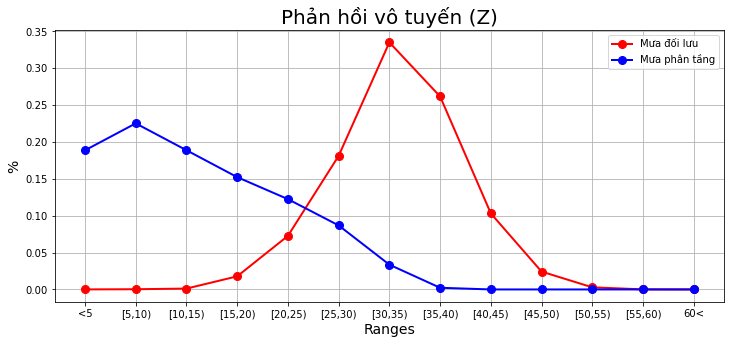

In [20]:
plt.figure(figsize=(12,5))
r_Z=['<5','[5,10)','[10,15)','[15,20)','[20,25)','[25,30)','[30,35)','[35,40)','[40,45)','[45,50)','[50,55)','[55,60)','60<']
plt.plot(r_Z,(df_Squall_line['Z_pre_C']+df_Full_Stratiform['Z_pre_C']+df_Embedded['Z_pre_C'])/(df_Squall_line['Z_pre_C']+df_Full_Stratiform['Z_pre_C']+df_Embedded['Z_pre_C']).sum(), linewidth=2,color='red', label="Mưa đối lưu",marker='o',markersize = 8)
plt.plot(r_Z, (df_Squall_line['Z_pre_S']+df_Full_Stratiform['Z_pre_S']+df_Embedded['Z_pre_S'])/(df_Squall_line['Z_pre_S']+df_Full_Stratiform['Z_pre_S']+df_Embedded['Z_pre_S']).sum(), linewidth=2,color='blue', label="Mưa phân tầng",marker='o',markersize = 8)
plt.title('Phản hồi vô tuyến (Z)', fontsize=20)
plt.xlabel('Ranges', fontsize=14)
plt.ylabel('%', fontsize=14)
plt.grid(True)
plt.legend(loc='upper right', ncol=1)
#plt.show()
plt.savefig('Reflectivity_6_events.png')

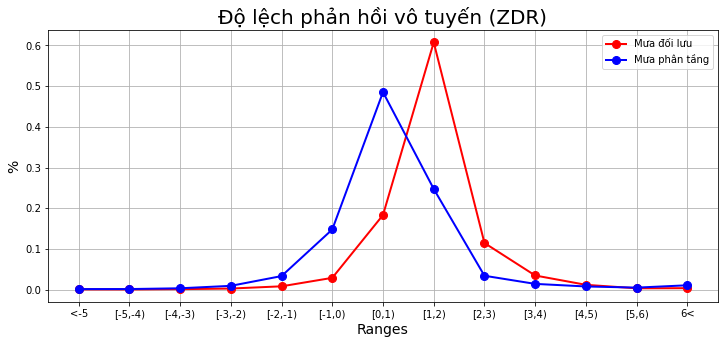

In [23]:
plt.figure(figsize=(12,5))
r_ZDR=['<-5','[-5,-4)','[-4,-3)','[-3,-2)','[-2,-1)','[-1,0)','[0,1)','[1,2)','[2,3)','[3,4)','[4,5)','[5,6)','6<',]
plt.plot(r_ZDR,(df_Squall_line['ZDR_pre_C']+df_Full_Stratiform['ZDR_pre_C']+df_Embedded['ZDR_pre_C'])/(df_Squall_line['ZDR_pre_C']+df_Full_Stratiform['ZDR_pre_C']+df_Embedded['ZDR_pre_C']).sum(), linewidth=2,color='red', label="Mưa đối lưu",marker='o',markersize = 8)
plt.plot(r_ZDR, (df_Squall_line['ZDR_pre_S']+df_Full_Stratiform['ZDR_pre_S']+df_Embedded['ZDR_pre_S'])/(df_Squall_line['ZDR_pre_S']+df_Full_Stratiform['ZDR_pre_S']+df_Embedded['ZDR_pre_S']).sum(), linewidth=2,color='blue', label="Mưa phân tầng",marker='o',markersize = 8)
plt.title('Độ lệch phản hồi vô tuyến (ZDR)', fontsize=20)
plt.xlabel('Ranges', fontsize=14)
plt.ylabel('%', fontsize=14)
plt.grid(True)
plt.legend(loc='upper right', ncol=1)
#plt.show()
plt.savefig('Differential_Reflectivity_6_events.png')

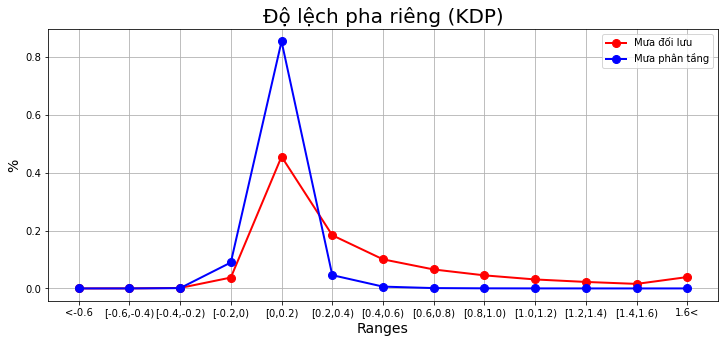

In [21]:
plt.figure(figsize=(12,5))
r_KDP=['<-0.6','[-0.6,-0.4)','[-0.4,-0.2)','[-0.2,0)','[0,0.2)','[0.2,0.4)','[0.4,0.6)','[0.6,0.8)','[0.8,1.0)','[1.0,1.2)','[1.2,1.4)','[1.4,1.6)','1.6<',]
plt.plot(r_KDP,(df_Squall_line['KDP_pre_C']+df_Full_Stratiform['KDP_pre_C']+df_Embedded['KDP_pre_C'])/(df_Squall_line['KDP_pre_C']+df_Full_Stratiform['KDP_pre_C']+df_Embedded['KDP_pre_C']).sum(), linewidth=2,color='red', label="Mưa đối lưu",marker='o',markersize = 8)
plt.plot(r_KDP, (df_Squall_line['KDP_pre_S']+df_Full_Stratiform['KDP_pre_S']+df_Embedded['KDP_pre_S'])/(df_Squall_line['KDP_pre_S']+df_Full_Stratiform['KDP_pre_S']+df_Embedded['KDP_pre_S']).sum(), linewidth=2,color='blue', label="Mưa phân tầng",marker='o',markersize = 8)
plt.title('Độ lệch pha riêng (KDP)', fontsize=20)
plt.xlabel('Ranges', fontsize=14)
plt.ylabel('%', fontsize=14)
plt.grid(True)
plt.legend(loc='upper right', ncol=1)
#plt.show()
plt.savefig('Specific_Differential_Phase_6_events.png')

In [30]:
datas = {
    'Z_pre_C': (df_Squall_line['Z_pre_C']+df_Full_Stratiform['Z_pre_C']+df_Embedded['Z_pre_C']),
    '%C_Z':round((df_Squall_line['Z_pre_C']+df_Full_Stratiform['Z_pre_C']+df_Embedded['Z_pre_C'])/((df_Squall_line['Z_pre_C']+df_Full_Stratiform['Z_pre_C']+df_Embedded['Z_pre_C']).sum()),2),
    'Z_pre_S': (df_Squall_line['Z_pre_S']+df_Full_Stratiform['Z_pre_S']+df_Embedded['Z_pre_S']),
    '%S_Z': round((df_Squall_line['Z_pre_S']+df_Full_Stratiform['Z_pre_S']+df_Embedded['Z_pre_S'])/((df_Squall_line['Z_pre_S']+df_Full_Stratiform['Z_pre_S']+df_Embedded['Z_pre_S']).sum()),2),
    'ZDR_pre_C': (df_Squall_line['ZDR_pre_C']+df_Full_Stratiform['ZDR_pre_C']+df_Embedded['ZDR_pre_C']),
    '%C_ZDR':round((df_Squall_line['ZDR_pre_C']+df_Full_Stratiform['ZDR_pre_C']+df_Embedded['ZDR_pre_C'])/(df_Squall_line['ZDR_pre_C']+df_Full_Stratiform['ZDR_pre_C']+df_Embedded['ZDR_pre_C']).sum(),2),
    'ZDR_pre_S': (df_Squall_line['ZDR_pre_S']+df_Full_Stratiform['ZDR_pre_S']+df_Embedded['ZDR_pre_S']),
    '%S_ZDR':round((df_Squall_line['ZDR_pre_S']+df_Full_Stratiform['ZDR_pre_S']+df_Embedded['ZDR_pre_S'])/((df_Squall_line['ZDR_pre_S']+df_Full_Stratiform['ZDR_pre_S']+df_Embedded['ZDR_pre_S']).sum()),2),
    'KDP_pre_C': (df_Squall_line['KDP_pre_C']+df_Full_Stratiform['KDP_pre_C']+df_Embedded['KDP_pre_C']),
    '%C_KDP':round((df_Squall_line['KDP_pre_C']+df_Full_Stratiform['KDP_pre_C']+df_Embedded['KDP_pre_C'])/(df_Squall_line['KDP_pre_C']+df_Full_Stratiform['KDP_pre_C']+df_Embedded['KDP_pre_C']).sum(),2),
    'KDP_pre_S': (df_Squall_line['KDP_pre_S']+df_Full_Stratiform['KDP_pre_S']+df_Embedded['KDP_pre_S']),
    '%S_KDP':round((df_Squall_line['KDP_pre_S']+df_Full_Stratiform['KDP_pre_S']+df_Embedded['KDP_pre_S'])/(df_Squall_line['KDP_pre_S']+df_Full_Stratiform['KDP_pre_S']+df_Embedded['KDP_pre_S']).sum(),2)
            }

In [31]:
df_6events=pd.DataFrame(data=datas)

In [32]:
zzz=df_6events.T

In [33]:
zzz.to_excel("Kết quả khảo sát tần xuất chọn ngưỡng.xlsx",sheet_name='Test_case_6_events')

In [34]:
with pd.ExcelWriter('Kết quả khảo sát tần xuất chọn ngưỡng.xlsx',engine="openpyxl",
                    mode='a') as writer:  
    df_6events.to_excel(writer, sheet_name='Sheet_name_1')
    df_Squall_line.to_excel(writer, sheet_name='Squall_line')
    df_Full_Stratiform.to_excel(writer, sheet_name='Full_Stratiform')
    df_Embedded.to_excel(writer, sheet_name='Embedded')

In [35]:
zzz

,0,1,2,3,4,5,6,7,8,9,10,11,12
Z_pre_C,14.00,68.00,280.00,4229.00,17287.00,43098.00,79715.00,62259.00,24532.00,5756.00,685.00,20.00,0.00
%C_Z,0.00,0.00,0.00,0.02,0.07,0.18,0.34,0.26,0.10,0.02,0.00,0.00,0.00
Z_pre_S,1060614.00,1265861.00,1061090.00,856128.00,688318.00,488088.00,188822.00,12810.00,0.00,0.00,0.00,0.00,0.00
%S_Z,0.19,0.23,0.19,0.15,0.12,0.09,0.03,0.00,0.00,0.00,0.00,0.00,0.00
ZDR_pre_C,125.00,88.00,258.00,619.00,1919.00,6874.00,43639.00,144678.00,27266.00,8250.00,2795.00,754.00,829.00
%C_ZDR,0.00,0.00,0.00,0.00,0.01,0.03,0.18,0.61,0.11,0.03,0.01,0.00,0.00
ZDR_pre_S,7203.00,7539.00,18169.00,51807.00,186687.00,830179.00,2727410.00,1390628.00,191132.00,78902.00,43301.00,27430.00,59522.00
%S_ZDR,0.00,0.00,0.00,0.01,0.03,0.15,0.49,0.25,0.03,0.01,0.01,0.00,0.01
KDP_pre_C,16.00,57.00,406.00,8967.00,108547.00,43813.00,23972.00,15627.00,10774.00,7412.00,5361.00,3750.00,9393.00
%C_KDP,0.00,0.00,0.00,0.04,0.46,0.18,0.10,0.07,0.05,0.03,0.02,0.02,0.04
